In [1]:
]st

    Status `C:\Users\juti\workspace\github\ReinforcementLearningAnIntroduction.jl\notebooks\Project.toml`
  [31c24e10] Distributions v0.21.1
  [91a5bcdd] Plots v0.26.3
  [02c1da58] RLIntro v0.2.0 [`..`]
  [158674fc] ReinforcementLearning v0.4.0 [`..\..\ReinforcementLearning.jl`]
  [25e41dd2] ReinforcementLearningEnvironments v0.1.1
  [2913bbd2] StatsBase v0.32.0
  [f3b207a7] StatsPlots v0.12.0
  [2f01184e] SparseArrays 


In [2]:
using StatsBase
using ReinforcementLearning, ReinforcementLearningEnvironments, RLIntro.MultiArmBandits
using Plots, StatsPlots

default(size=(800, 600))

┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1273


In [3]:
env = MultiArmBanditsEnv()

MultiArmBanditsEnv([-0.2656946086732855, -0.25730857707711774, -0.43182909525105034, -1.1852592287853994, -1.4309007003410694, 0.3554407246992938, 2.1633444427648323, -0.06908955650217691, 0.046794489654736614, -0.22395304049473574], 0.0, 7, false, 0.0, false, DiscreteSpace{Int64}(1, 1, 1), DiscreteSpace{Int64}(1, 10, 10))

Let's visualize the possible rewards for each action first:

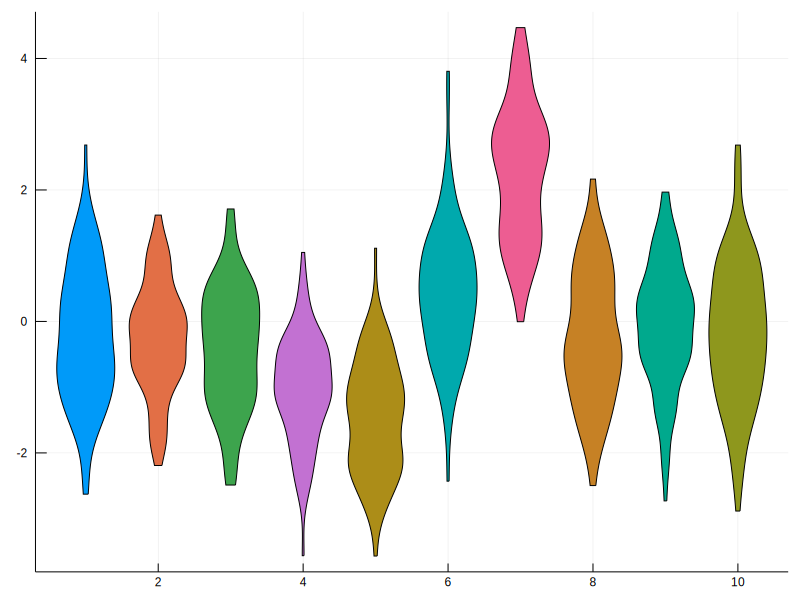

In [4]:
violin([randn(100) .+ x for x in env.truevalues], leg=false)

Here we define a customized hook first to collect the info that our action is the best one or not.

In [5]:
struct CollectBestActions <: AbstractHook
    isbest::Vector{Bool}
    CollectBestActions() = new(Vector{Bool}())
end

(h::CollectBestActions)(::PostActStage, agent, env, action_obs) = push!(h.isbest, env.isbest)

Now we create a testbed to explore the impact of different ϵ.

In [6]:
function bandit_testbed(;selector=EpsilonGreedySelector(0.1), truereward=0.0, init=0., opt=InvDecay(1.0))
    env = MultiArmBanditsEnv(truereward=truereward)
    agent = Agent(
        QBasedPolicy(
            TDLearner(
                approximator = TabularQApproximator(
                    n_state=length(observation_space(env)),
                    n_action=length(action_space(env)),
                    init=init
                ),
                optimizer = opt
            ),
            selector
        ),
        episode_RTSA_buffer()
    )
    best_action_stats, reward_stats = CollectBestActions(), RewardsPerEpisode()
    run(agent, env, StopAfterStep(1000);hook=ComposedHook(best_action_stats, reward_stats))
    collect(Iterators.flatten(reward_stats.rewards)),best_action_stats.isbest
end

bandit_testbed (generic function with 1 method)

Progress:   0%|█                                        |  ETA: 0:05:14
4m  TRAINING/STEP:  1
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  TRAINING/STEP:  999
Progress:  96%|████████████████████████████████████████ |  ETA: 0:00:00
4m  TRAINING/STEP:  956
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  TRAINING/STEP:  999


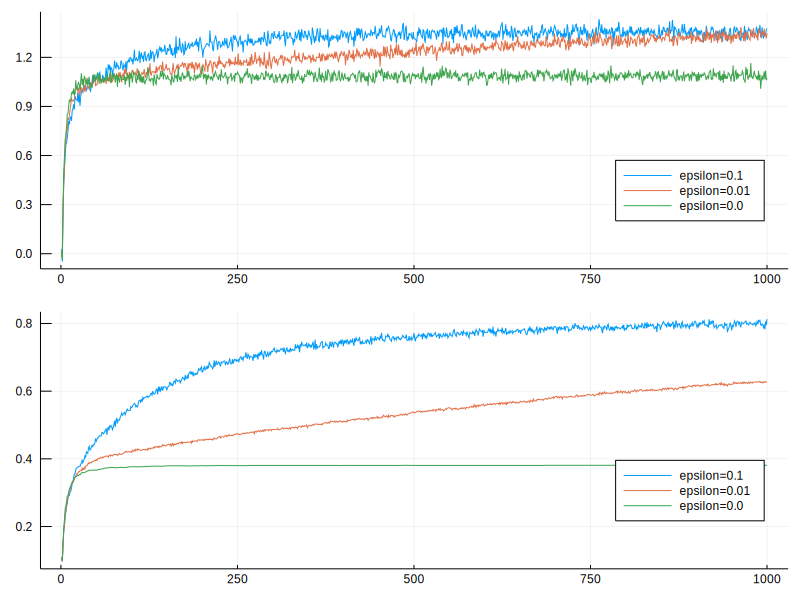

In [7]:
p = plot(layout=(2, 1))
for ϵ in [0.1, 0.01, 0.0]
    stats = [bandit_testbed(;selector=EpsilonGreedySelector(ϵ)) for _ in 1:2000]
    plot!(p, mean(x[1] for x in stats), subplot=1, legend=:bottomright, label="epsilon=$ϵ")
    plot!(p, mean(x[2] for x in stats), subplot=2, legend=:bottomright, label="epsilon=$ϵ")
end

p

Progress:   0%|█                                        |  ETA: 0:01:57
4m  TRAINING/STEP:  1
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  TRAINING/STEP:  999


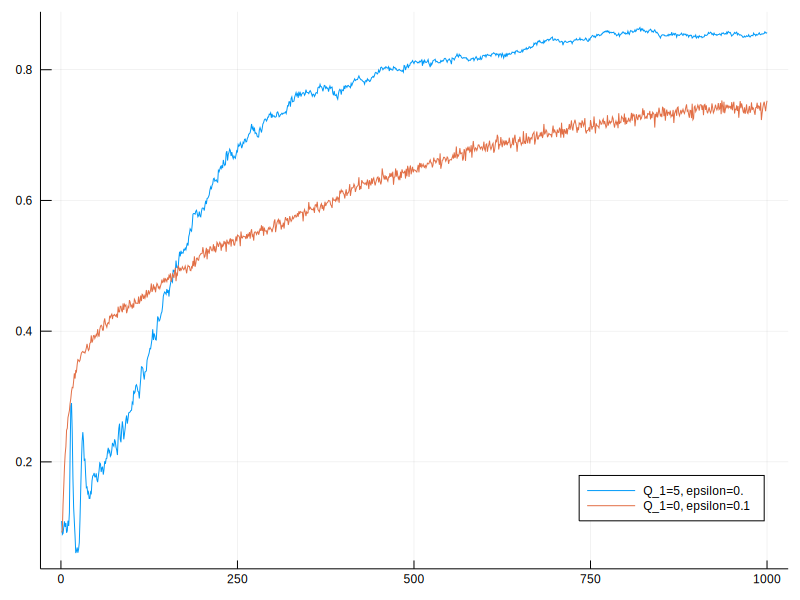

In [8]:
p = plot(legend=:bottomright)
plot!(p, mean(bandit_testbed(;selector=EpsilonGreedySelector(0.), init=5., opt=Descent(0.1))[2] for _ in 1:2000), label="Q_1=5, epsilon=0.")
plot!(p, mean(bandit_testbed(;selector=EpsilonGreedySelector(0.1), init=0., opt=Descent(0.1))[2] for _ in 1:2000), label="Q_1=0, epsilon=0.1")

Progress:  76%|███████████████████████████████          |  ETA: 0:00:00
4m  TRAINING/STEP:  754
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  TRAINING/STEP:  999


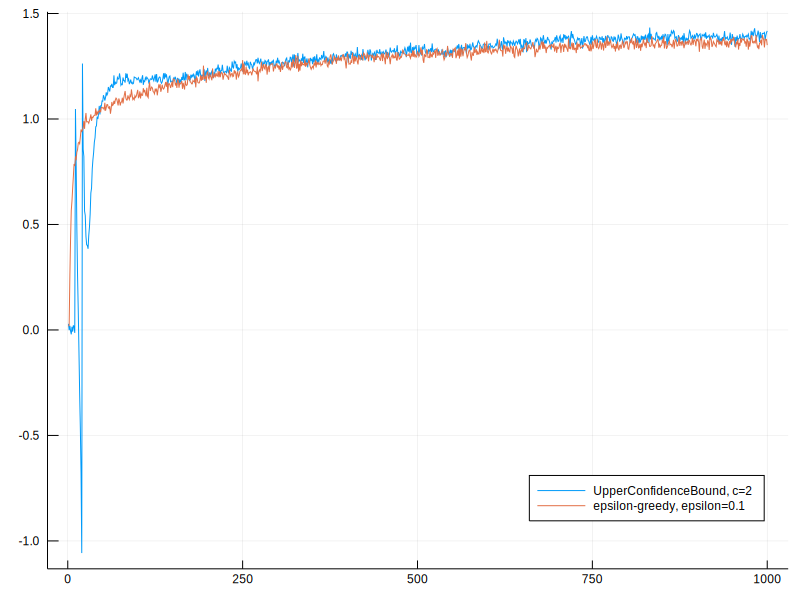

In [13]:
p = plot(legend=:bottomright)
plot!(p, mean(bandit_testbed(;selector=UCBSelector(10), opt=Descent(0.1))[1] for _ in 1:5000), label="UpperConfidenceBound, c=2")
plot!(p, mean(bandit_testbed(;selector=EpsilonGreedySelector(0.1), opt=Descent(0.1))[1] for _ in 1:5000), label="epsilon-greedy, epsilon=0.1")

p

In [10]:
function gb_bandit_testbed(;baseline=0., selector=WeightedSelector(true), truereward=0.0, init=0., opt=InvDecay(1.0))
    env = MultiArmBanditsEnv(truereward=truereward)
    agent = Agent(
        QBasedPolicy(
            GradientBanditLearner(
                approximator=TabularQApproximator(
                    n_state=length(observation_space(env)),
                    n_action=length(action_space(env)),
                    init=init
                ),
                optimizer=opt,
                baseline=baseline
            ),
            selector
        ),
        episode_RTSA_buffer()
    )
    best_action_stats, reward_stats = CollectBestActions(), RewardsPerEpisode()
    run(agent, env, StopAfterStep(1000);hook=ComposedHook(best_action_stats, reward_stats))
    collect(Iterators.flatten(reward_stats.rewards)),best_action_stats.isbest
end

gb_bandit_testbed (generic function with 1 method)

As you can see, the only difference of `gb_bandit_testbed` compared to `bandit_testbed` is that it uses `GradientBanditLearner` instread of `TDLearner`.

Progress:   0%|█                                        |  ETA: 0:02:48
4m  TRAINING/STEP:  1
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  TRAINING/STEP:  999
Progress:   0%|█                                        |  ETA: 0:01:06
4m  TRAINING/STEP:  1
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  TRAINING/STEP:  999


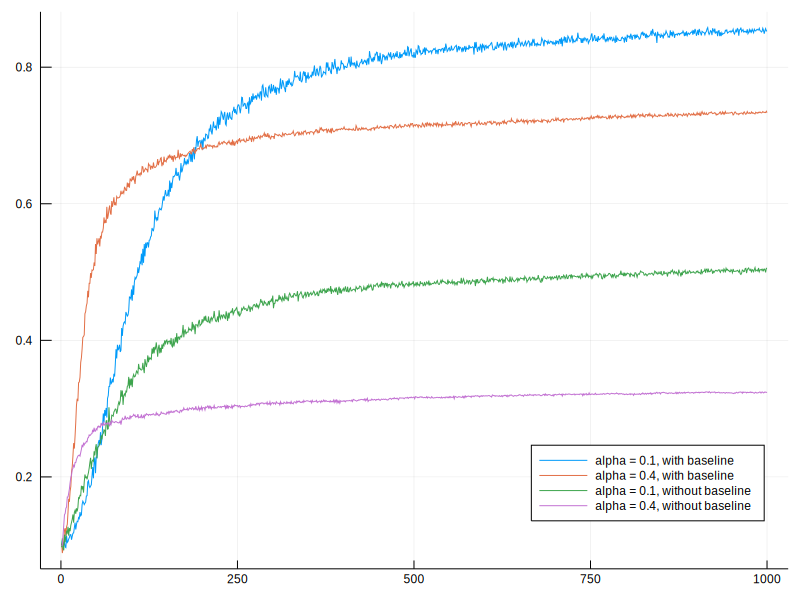

In [14]:
truereward = 4.0

p = plot(legend=:bottomright)

plot!(p, mean(gb_bandit_testbed(;opt=Descent(0.1), baseline=SampleAvg(), truereward=truereward)[2] for _ in 1:2000), label="alpha = 0.1, with baseline")
plot!(p, mean(gb_bandit_testbed(;opt=Descent(0.4), baseline=SampleAvg(), truereward=truereward)[2] for _ in 1:2000), label="alpha = 0.4, with baseline")
plot!(p, mean(gb_bandit_testbed(;opt=Descent(0.1), truereward=truereward)[2] for _ in 1:2000), label="alpha = 0.1, without baseline")
plot!(p, mean(gb_bandit_testbed(;opt=Descent(0.4), truereward=truereward)[2] for _ in 1:2000), label="alpha = 0.4, without baseline")

p

Progress:  79%|█████████████████████████████████        |  ETA: 0:00:00
4m  TRAINING/STEP:  786
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  TRAINING/STEP:  999
Progress:  97%|████████████████████████████████████████ |  ETA: 0:00:00
4m  TRAINING/STEP:  967
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  TRAINING/STEP:  999
Progress:  88%|████████████████████████████████████     |  ETA: 0:00:00
4m  TRAINING/STEP:  877
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  TRAINING/STEP:  999
Progress:  67%|████████████████████████████             |  ETA: 0:00:00
4m  TRAINING/STEP:  667
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  TRAINING/STEP:  999
Progress:   0%|█                                        |  ETA: 0:01:01
4m  TRAINING/STEP:  1
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  TRAINING/STEP:  999
Progress:  73%|██████████████████████████████       

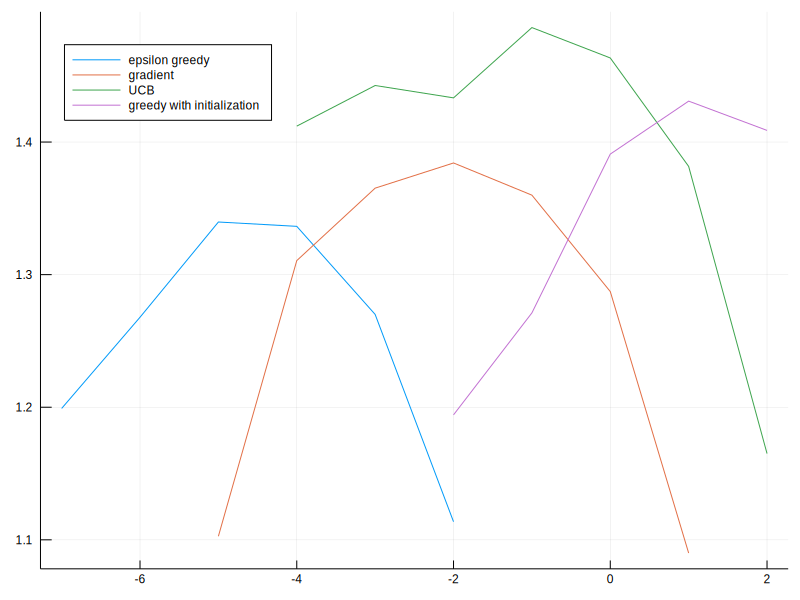

In [15]:
p = plot(legend=:topleft)

plot!(p, -7:-2, [mean(mean(bandit_testbed(;selector=EpsilonGreedySelector(2.0^i))[1] for _ in 1:2000)) for i in -7:-2], label="epsilon greedy")
plot!(p, -5:1, [mean(mean(gb_bandit_testbed(;selector=WeightedSelector(true), opt=Descent(2.0^i))[1] for _ in 1:2000)) for i in -5:1], label="gradient")
plot!(p, -4:2, [mean(mean(bandit_testbed(;selector=UCBSelector(10; c=2.0^i))[1] for _ in 1:2000)) for i in -4:2], label="UCB")
plot!(p, -2:2, [mean(mean(bandit_testbed(;selector=EpsilonGreedySelector(0.), init=(2.0^i))[1] for _ in 1:2000)) for i in -2:2], label="greedy with initialization")

p